In [1]:
from utilities import *

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold,  RepeatedStratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from scipy.stats import randint
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

In [2]:
#dataset = load_dataset("Train")
#X,y = create_features_matrix_Khened(dataset, category=True, save=False)
X = np.load("saves/train_features_Khened.npy")
X_test = np.load("saves/test_features_Khened.npy")
y = np.load("saves/categories.npy")
print(f"Number of features: {X.shape[1]}")
TRAIN = False

Number of features: 20


In [3]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

In [4]:
svm_params_grid = {
    'C': [1, 10, 100, 1000],
    'gamma': [0.001, 0.0001],
    'kernel': ['rbf']
}

rf_params_grid = {
    "n_estimators": [1000],
    "max_depth": [None],
    "min_samples_split": randint(5, 30),
    "min_samples_leaf": randint(5, 30),
    "max_features": ["sqrt", "log2", None],
    "criterion": ["gini", "entropy"],
    "bootstrap": [True, False]
}

gnb_params_grid = {
    "var_smoothing": [1e-9, 1e-10,1e-8]
}

In [5]:
if TRAIN:
    clfs = []
    for clf, params, name in zip([SVC(random_state=0,probability=True), RandomForestClassifier(random_state=0), GaussianNB()], [svm_params_grid, rf_params_grid, gnb_params_grid], ["SVM", "Random Forest", "Gaussian Naive Bayes"]):
        print(f"Training {name}")
        if name == "Random Forest":
            grid = RandomizedSearchCV(clf, params, n_iter=50, cv=5, n_jobs=-1)
        else:
            grid = GridSearchCV(clf, params, cv=5, n_jobs=-1,)
        grid.fit(X, y)
        print(f"Best parameters: {grid.best_params_}")
        print(f"Best score: {grid.best_score_}")
        clfs.append(grid.best_estimator_)
        print(f"Done {name}")
        print("\n")

else:
    svm = SVC(C=100, gamma=0.001, kernel='rbf', probability=True, random_state=0)
    rf = RandomForestClassifier(n_estimators=1000, max_depth=None, min_samples_split=10, min_samples_leaf=7, max_features="log2", criterion='entropy', bootstrap=True, random_state=0)
    gnb = GaussianNB(var_smoothing=1e-9)
    clfs = [svm, rf, gnb]
    

In [6]:
def stage1(X, y, svm, rf, gnb, print_scores=False):
    mlp = MLPClassifier(hidden_layer_sizes=(100, 100), random_state=0, max_iter=1000)
    eclf = VotingClassifier(estimators=[
        ('svm', svm), ('rf', rf), ('gnb', gnb), ('mlp',mlp)], voting='soft')
    if print_scores:
        scores = cross_val_score(eclf, X, y, cv=5, n_jobs=-1)
        print(f"Cross-validation Accuracy: {np.mean(scores)} +/- {np.std(scores)}")
    eclf = eclf.fit(X, y)
    return eclf

def stage2(X, y, X_test, y_pred):
    X_train = X[(y == 1.) | (y == 2.)]
    X_train = X_train[:,16:20]
    round2 = []
    for i,pred in enumerate(y_pred):
        if pred == 1 or pred == 2:
            round2.append(i)
    Xround2 = X_test[round2][:,16:20]
    mlp = MLPClassifier(hidden_layer_sizes=(100,100), random_state=0, max_iter=1000, solver='lbfgs')
    mlp.fit(X_train, y[(y == 1) | (y == 2)])
    y_pred2 = mlp.predict(Xround2)
    y_pred[round2] = y_pred2
    return y_pred

def predictions(X, y, X_test, clfs, print_scores=False):
    clf = stage1(X, y, clfs[0], clfs[1], clfs[2], print_scores)
    y_pred = clf.predict(X_test)
    y_pred = stage2(X, y, X_test, y_pred)
    return y_pred

In [7]:
y_pred = predictions(X, y, X_test, clfs, print_scores=True)

Cross-validation Accuracy: 0.96 +/- 0.020000000000000018


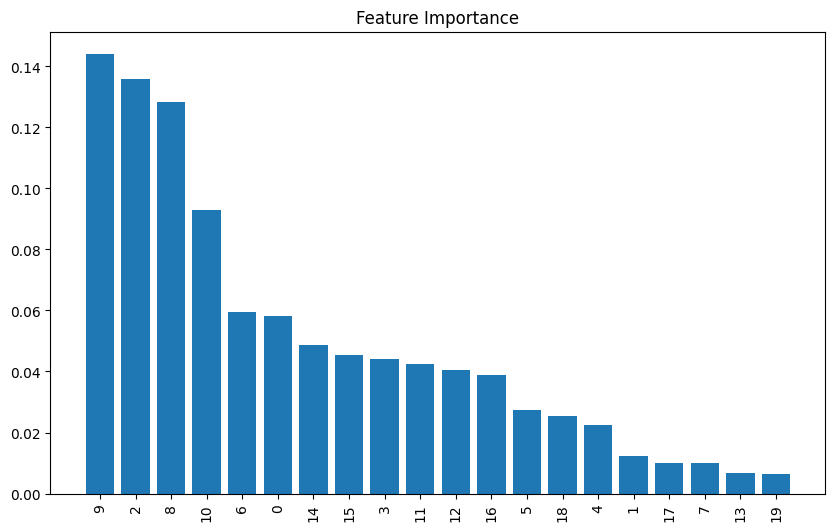

In [8]:
rf.fit(X, y)

importances = rf.feature_importances_

index = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.title("Feature Importance")
plt.bar(range(len(importances)), importances[index], align="center")
plt.xticks(range(len(importances)),index, rotation=90)
plt.show()

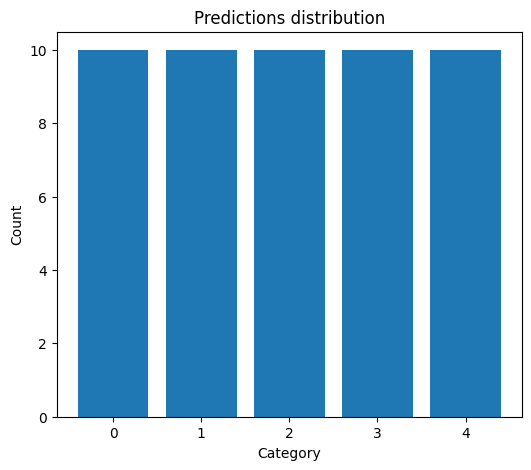

Submission file submission_Khened.csv created


In [9]:
submission(y_pred, "submission_Khened", plot=True)